# Monte-Carlo Cardinality Estimation with ORIGAMI

We have a discrete factorised probability distribution of the form:
$$
f(\mathbf{x}) = f(x_1)\cdot f(x_2 | x_1)\cdot \ldots \cdot f(x_n | x_{<n})
$$
We are interested in a sum $S = \sum_{x \in E} f(\mathbf{x})$ over all $x$ from a subset $E$ (a query region), as this represents the probability of seeing data in region $E$ (which equates to cardinality estimation of a query represented by region $E$).

It is usually intractable to enumerate all elements $x \in E$ completely, especially in higher-dimensional spaces and with continuous (or high cardinality) fields. 

However, we can use Monte Carlo Sampling to approximate the sum $S$.

### Monte-Carlo Method

We begin with the base case, showing how $S$ can be approximated with Monte-Carlo. 

We define a Random Variable $X$ in the context of a probability space with:
- $\Omega = E$, the query region
- a $\sigma$-algebra $\mathcal{F}$ as the power set $\mathcal{P}(\Omega)$
- a uniform probability distribution $P : \Omega \rightarrow [0, 1] = \mathrm{Unif}(E)$ distributed over $E$, with $p(x) = \frac{1}{|E|}$ for all x. We choose the uniform distribution to make the expectations below easier to work with (stuff cancels out).

The random variable is defined as $X = f(\mathbf x)$.

The expectation of $X$ is:

$$
\mathbb{E}[X] = \sum_{x \in E} f(x) \cdot p(x) = \frac{1}{|E|} \sum_{x \in E} f(x) 
$$

This is very close to the sum $S$ we want to approximate (see above), apart from the fraction $\frac{1}{|E|}$. Therefore, we can express $S$ as:

$$
S = \sum_{x \in E} f(x) = |E|\cdot \mathbb{E}[X]
$$

With Monte Carlo, we can now approximate the expectation term, and get an estimator for $S$:
$$
\hat{S}_{MC} = |E| \cdot \frac{1}{N} \sum_{i=1}^N f(x^{(j)}) 
$$
where we draw $N$ samples $x^{(j)}$ i.i.d. from our probability distribution $P$ uniformly, i.e. choosing each $x^{(j)}$ with equal probability (we do not sample from the learned model distribution $f$ here).

To calculate $|E| = |E_1| \cdot |E_2| \ldots |E_n|$, we determine $|E_i|$ as the number of discrete values (for numeric fields, the number of bins) for field $i$ that fall within the query range for that field. This gives us the total number of discrete states (bin combinations) in the query region $E$. Evaluating $f(\mathbf x)$ is also efficient and can be done in a single forward pass as a point estimate.

## Create 2D Gaussian Dataset

In [1]:
# Generate 2D data with gaussian distribution
from copy import deepcopy
from pprint import pprint

import numpy as np
import pandas as pd

NUM_DOCS = 20000

# Create a Pandas dataframe with documents of a and b fields following a 2D Gaussian distribution
df = pd.DataFrame()
mean = [4, -2]

# Skewed covariance matrix to make the data correlated
cov = [[1.0, 0.6], [0.8, 0.3]]

a, b = np.random.multivariate_normal(mean, cov, NUM_DOCS).T
docs = [{"a": float(x), "b": float(y)} for x, y in zip(a, b)]
df["docs"] = deepcopy(docs)

pprint(docs[:3])
df.head()

[{'a': 4.724219201820224, 'b': -1.7107442234057344},
 {'a': 2.457402817524013, 'b': -2.485910743749877},
 {'a': 2.41122140552603, 'b': -2.631345400350688}]


/var/folders/cp/r86_5xy15c564s3wsczlqgrc0000gn/T/ipykernel_26448/1554998531.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  a, b = np.random.multivariate_normal(mean, cov, NUM_DOCS).T


,docs
0,"{'a': 4.724219201820224, 'b': -1.7107442234057..."
1,"{'a': 2.457402817524013, 'b': -2.485910743749877}"
2,"{'a': 2.41122140552603, 'b': -2.631345400350688}"
3,"{'a': 4.17341632206889, 'b': -1.1970111085105208}"
4,"{'a': 4.481889584618136, 'b': -1.868139158970037}"


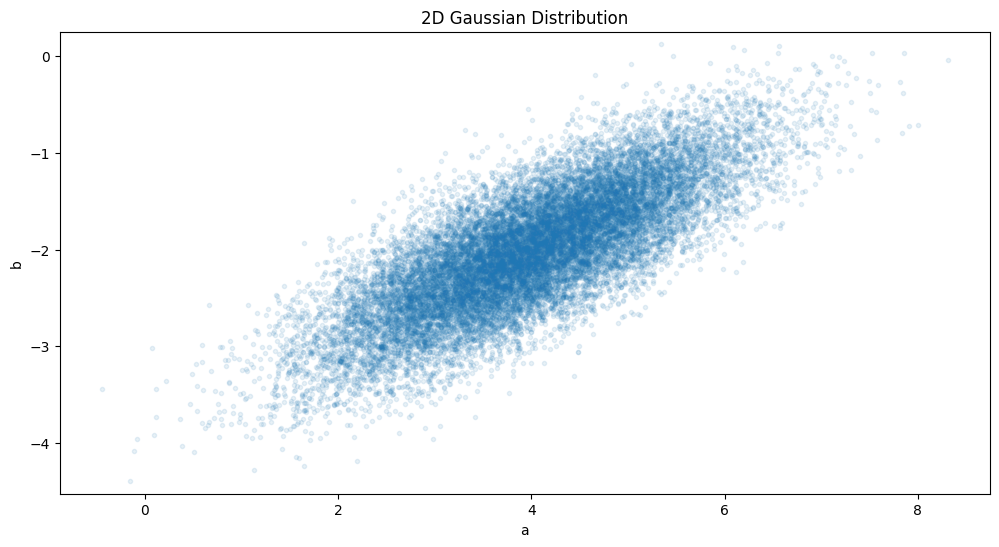

In [2]:
# Plot the data in a 2d scatter plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter([doc["a"] for doc in df["docs"]], [doc["b"] for doc in df["docs"]], marker=".", alpha=0.1)

plt.title("2D Gaussian Distribution")
plt.xlabel("a")
plt.ylabel("b")
plt.axis("equal")
plt.show()

## Set up the Data Processing Pipeline

In [3]:
from sklearn.pipeline import Pipeline

from origami.preprocessing import (
    DocTokenizerPipe,
    KBinsDiscretizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    SortFieldsPipe,
    TokenEncoderPipe,
    # load_df_from_mongodb,   use this if loading data from mongodb
)
from origami.utils import set_seed

# For reproducibility
set_seed(123)

# Here we use the generated 2D gaussian DataFrame as an example
# But this could be replaced with a call to load_df_from_mongodb
# df = load_df_from_mongodb(...)

NUM_BINS = 50
STRATEGY = "uniform"

# Create data pipeline (we don't use the build_prediction_pipelines() utility here because we need to set custom binning parameters)
pipeline = Pipeline(
    [
        ("binning", KBinsDiscretizerPipe(bins=NUM_BINS, strategy=STRATEGY)),
        ("sortfields", SortFieldsPipe()),
        ("schema", SchemaParserPipe()),
        # No upscaler or permuter, it's not needed for MC estimation
        ("tokenizer", DocTokenizerPipe()),
        ("padding", PadTruncTokensPipe(length="max")),
        ("encoder", TokenEncoderPipe()),
    ],
)

# Process data
processed_df = pipeline.fit_transform(df).reset_index(drop=True)

# Get stateful objects
schema = pipeline["schema"].schema
encoder = pipeline["encoder"].encoder
block_size = pipeline["padding"].length

# Print data stats
print(f"len train: {len(processed_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

len train: 20000
vocab size 111
block size 7


In [4]:
processed_df.head()

,docs,tokens
0,"{'a': 4.7192662891095285, 'b': -1.729087340179...","[1, 10, 11, 12, 13, 2, 0]"
1,"{'a': 2.4445744941008787, 'b': -2.453513552906...","[1, 10, 14, 12, 15, 2, 0]"
2,"{'a': 2.4445744941008787, 'b': -2.634620106088...","[1, 10, 14, 12, 16, 2, 0]"
3,"{'a': 4.194337413338302, 'b': -1.185767680633709}","[1, 10, 17, 12, 18, 2, 0]"
4,"{'a': 4.544289997185787, 'b': -1.9101938933611...","[1, 10, 19, 12, 20, 2, 0]"


## Train ORiGAMi Model

Here we instantiate an ORiGAMi model, a modified transformer trained on the token sequences created above.
We use a standard "medium" configuration. ORiGAMi models are relatively robust to the choice of hyper-parameter
and default configurations often work well for mid-sized datasets.

In [5]:
from origami.model import ORIGAMI
from origami.model.vpda import ObjectVPDA
from origami.preprocessing import DFDataset
from origami.utils import ModelConfig, TrainConfig, count_parameters

# Model and train configs
model_config = ModelConfig.from_preset("medium")  # "small" also works, see origami/utils/config.py for more presets
model_config.position_encoding = "KEY_VALUE"
model_config.vocab_size = encoder.vocab_size
model_config.block_size = block_size

train_config = TrainConfig()
train_config.learning_rate = 5e-4
train_config.print_every = 100

# Wrap dataframe in datasets
dataset = DFDataset(processed_df)

# Create PDA and pass it to the model
vpda = ObjectVPDA(encoder, schema)
model = ORIGAMI(model_config, train_config, vpda=vpda)

n_params = count_parameters(model)
print(f"Number of parameters: {n_params / 1e6:.2f}M")

Number of parameters: 2.71M


In [6]:
from origami.utils import make_progress_callback

# Create and register progress callback
progress_callback = make_progress_callback(train_config, train_dataset=dataset)
model.set_callback("on_batch_end", progress_callback)
model.train_model(dataset, batches=5000)

|  step: 0  |  epoch: 0  |  batch_num: 0  |  batch_dt: 0.00  |  batch_loss: 2.5748  |  lr: 5.05e-07  |
|  step: 1  |  epoch: 0  |  batch_num: 100  |  batch_dt: 38.52  |  batch_loss: 1.3757  |  lr: 5.05e-05  |
|  step: 2  |  epoch: 1  |  batch_num: 200  |  batch_dt: 37.42  |  batch_loss: 1.3333  |  lr: 1.01e-04  |
|  step: 3  |  epoch: 1  |  batch_num: 300  |  batch_dt: 37.98  |  batch_loss: 1.2777  |  lr: 1.51e-04  |
|  step: 4  |  epoch: 2  |  batch_num: 400  |  batch_dt: 37.93  |  batch_loss: 1.2476  |  lr: 2.01e-04  |
|  step: 5  |  epoch: 2  |  batch_num: 500  |  batch_dt: 37.31  |  batch_loss: 1.2433  |  lr: 2.51e-04  |
|  step: 6  |  epoch: 3  |  batch_num: 600  |  batch_dt: 38.85  |  batch_loss: 1.2671  |  lr: 3.01e-04  |
|  step: 7  |  epoch: 3  |  batch_num: 700  |  batch_dt: 37.65  |  batch_loss: 1.2628  |  lr: 3.51e-04  |
|  step: 8  |  epoch: 4  |  batch_num: 800  |  batch_dt: 38.95  |  batch_loss: 1.2354  |  lr: 4.01e-04  |
|  step: 9  |  epoch: 4  |  batch_num: 900  |  ba

In [7]:
# Load/save model
# model.load("origami_gauss_checkpoint.pt")
# model.save("origami_gauss_checkpoint.pt")

## Cardinality Estimation: MC vs Rejection Sampling

We'll compare two approaches for cardinality estimation:

1. **Monte Carlo (MC) Sampling**: Samples uniformly in the query region, weights by model probability
2. **Rejection Sampling**: Samples from model distribution, counts acceptance rate

Both are unbiased estimators but work best in different scenarios.

### Single Query Example

Let's start with a single query to see how both estimators work.

In [56]:
from mdbrtools.query import parse_from_mql

from origami.inference import MCEstimator, RejectionEstimator, Sampler
from origami.utils import compare_estimate_to_ground_truth

# Create both estimators
mc_estimator = MCEstimator(model, pipeline)
sampler = Sampler(model, encoder, schema)
rejection_estimator = RejectionEstimator(sampler)

# Define a query
query_dict = {"a": {"$gte": 1, "$lte": 3}, "b": {"$gte": -3, "$lte": -2}}
query = parse_from_mql(query_dict)

# Get estimates from both methods (both return selectivity/probability)
mc_p, mc_samples = mc_estimator.estimate(query, n=1000)
rej_p, rej_samples = rejection_estimator.estimate(query, n=1000)

# Compare to ground truth
mc_result = compare_estimate_to_ground_truth(query, docs, mc_p)
rej_result = compare_estimate_to_ground_truth(query, docs, rej_p)

# Print results
print(f"Query: {query_dict}")
print()
print(f"Ground Truth Count:       {mc_result['ground_truth_count']}")
print()
print("=" * 80)
print("MONTE CARLO ESTIMATOR")
print("=" * 80)
print(f"Estimated Count:          {mc_result['estimated_count']:.1f}")
print(
    f"Estimated Selectivity:    {mc_result['estimated_selectivity']:.4f} ({mc_result['estimated_selectivity'] * 100:.2f}%)"
)
print(f"Q-Error:                  {mc_result['q_error']:.2f}x")
print(f"Relative Error:           {mc_result['relative_error']:.2%}")
print(f"Samples generated:        {len(mc_samples)}")
print()
print("=" * 80)
print("REJECTION SAMPLING ESTIMATOR")
print("=" * 80)
print(f"Estimated Count:          {rej_result['estimated_count']:.1f}")
print(
    f"Estimated Selectivity:    {rej_result['estimated_selectivity']:.4f} ({rej_result['estimated_selectivity'] * 100:.2f}%)"
)
print(f"Q-Error:                  {rej_result['q_error']:.2f}x")
print(f"Relative Error:           {rej_result['relative_error']:.2%}")
print(f"Samples accepted:         {len(rej_samples)}/1000 ({len(rej_samples) / 10:.1f}%)")

Query: {'a': {'$gte': 1, '$lte': 3}, 'b': {'$gte': -3, '$lte': -2}}

Ground Truth Count:       2567

MONTE CARLO ESTIMATOR
Estimated Count:          2808.4
Estimated Selectivity:    0.1404 (14.04%)
Q-Error:                  1.09x
Relative Error:           9.40%
Samples generated:        1000

REJECTION SAMPLING ESTIMATOR
Estimated Count:          3060.0
Estimated Selectivity:    0.1530 (15.30%)
Q-Error:                  1.19x
Relative Error:           19.21%
Samples accepted:         153/1000 (15.3%)


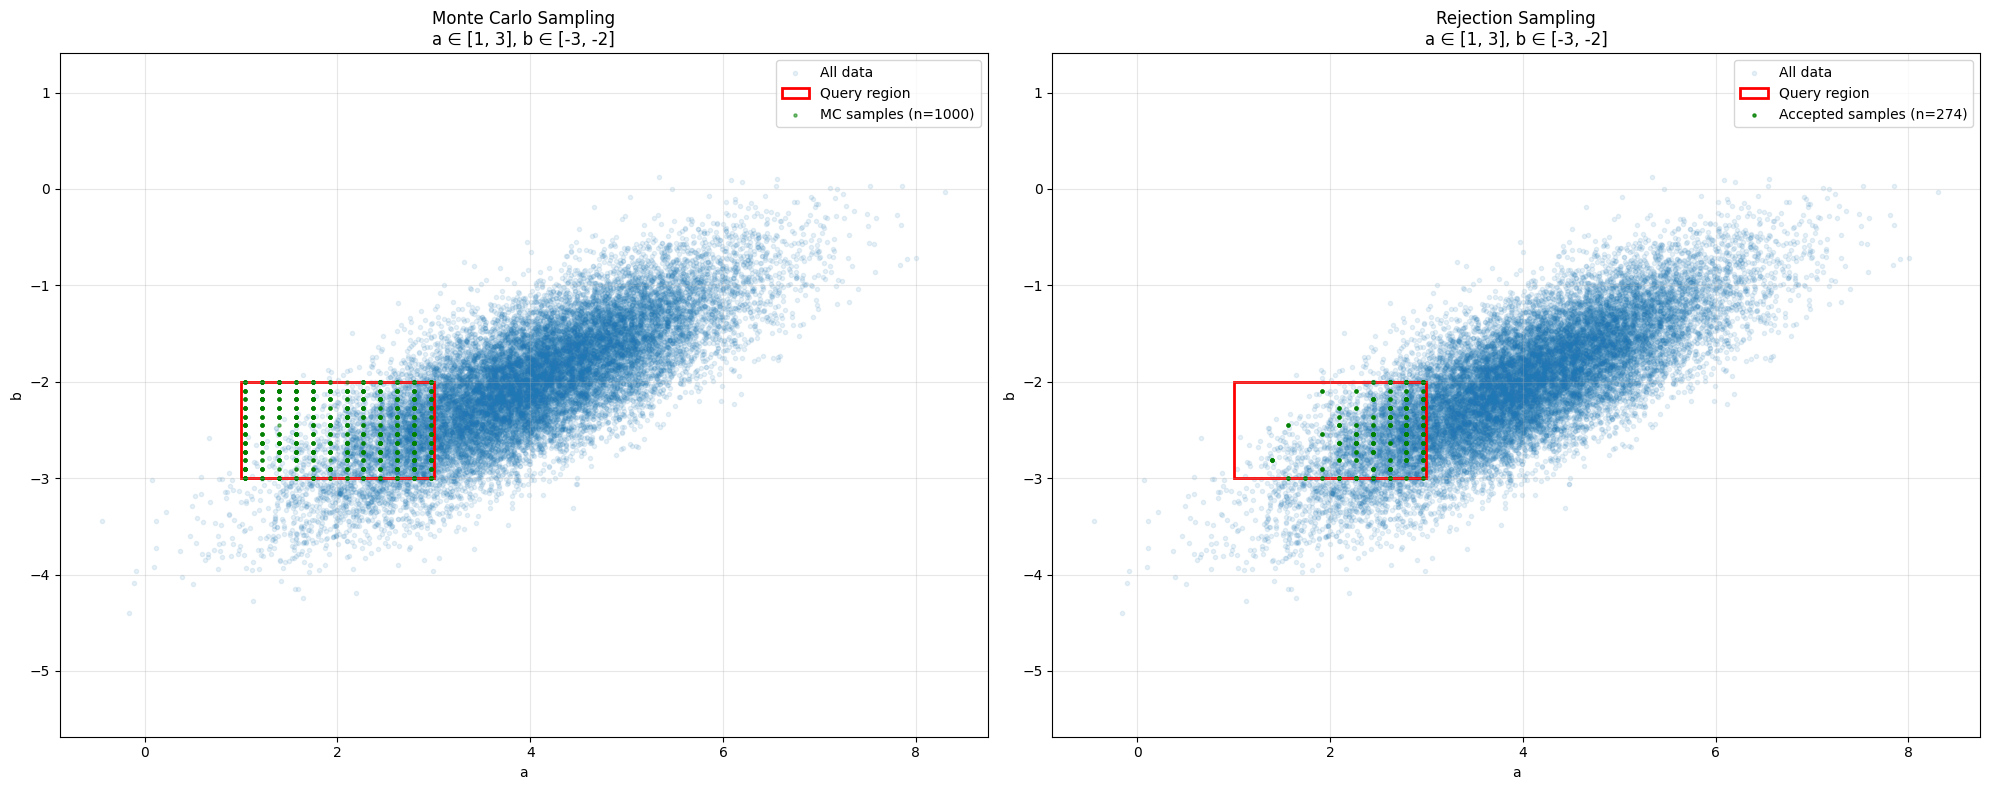

MC Verification:        1000/1000 samples are inside the query region
Rejection Verification: 274/274 samples are inside the query region


In [9]:
# Visualize the query region and generated samples from both estimators
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Extract query bounds from the query dict
a_min, a_max = query_dict["a"]["$gte"], query_dict["a"]["$lte"]
b_min, b_max = query_dict["b"]["$gte"], query_dict["b"]["$lte"]

# Left plot: MC Estimator
axes[0].scatter([doc["a"] for doc in docs], [doc["b"] for doc in docs], marker=".", alpha=0.1, label="All data")
rect_mc = patches.Rectangle(
    (a_min, b_min), a_max - a_min, b_max - b_min, linewidth=2, edgecolor="red", facecolor="none", label="Query region"
)
axes[0].add_patch(rect_mc)
mc_sample_a = [s["a"] for s in mc_samples]
mc_sample_b = [s["b"] for s in mc_samples]
axes[0].scatter(
    mc_sample_a, mc_sample_b, marker=".", alpha=0.5, c="green", s=20, label=f"MC samples (n={len(mc_samples)})"
)
axes[0].set_title(f"Monte Carlo Sampling\na ∈ [{a_min}, {a_max}], b ∈ [{b_min}, {b_max}]")
axes[0].set_xlabel("a")
axes[0].set_ylabel("b")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis("equal")

# Right plot: Rejection Estimator
axes[1].scatter([doc["a"] for doc in docs], [doc["b"] for doc in docs], marker=".", alpha=0.1, label="All data")
rect_rej = patches.Rectangle(
    (a_min, b_min), a_max - a_min, b_max - b_min, linewidth=2, edgecolor="red", facecolor="none", label="Query region"
)
axes[1].add_patch(rect_rej)
rej_sample_a = [s["a"] for s in rej_samples]
rej_sample_b = [s["b"] for s in rej_samples]
axes[1].scatter(
    rej_sample_a, rej_sample_b, marker=".", alpha=0.8, c="green", s=20, label=f"Accepted samples (n={len(rej_samples)})"
)
axes[1].set_title(f"Rejection Sampling\na ∈ [{a_min}, {a_max}], b ∈ [{b_min}, {b_max}]")
axes[1].set_xlabel("a")
axes[1].set_ylabel("b")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis("equal")

plt.tight_layout()
plt.show()

# Print verification
mc_samples_in_region = sum(1 for s in mc_samples if a_min <= s["a"] <= a_max and b_min <= s["b"] <= b_max)
rej_samples_in_region = sum(1 for s in rej_samples if a_min <= s["a"] <= a_max and b_min <= s["b"] <= b_max)
print(f"MC Verification:        {mc_samples_in_region}/{len(mc_samples)} samples are inside the query region")
print(f"Rejection Verification: {rej_samples_in_region}/{len(rej_samples)} samples are inside the query region")

### Evaluate Estimators Across Multiple Random Queries

Now let's evaluate how well both estimators work across many different random query ranges.

In [10]:
# Helper function to generate random query ranges
def generate_random_query_range(
    data_min: float,
    data_max: float,
    min_fraction: float = 0.05,
    max_fraction: float = 0.5,
) -> tuple[float, float]:
    """Generate a random query range within the data bounds.

    Args:
        data_min: Minimum value in the data
        data_max: Maximum value in the data
        min_fraction: Minimum fraction of the full range (default 5%)
        max_fraction: Maximum fraction of the full range (default 50%)

    Returns:
        (range_min, range_max): The query range bounds
    """
    full_range = data_max - data_min

    # Random range size between min_fraction and max_fraction of full range
    range_size = np.random.uniform(min_fraction * full_range, max_fraction * full_range)

    # Random starting point ensuring the range fits within data bounds
    max_start = data_max - range_size
    range_min = np.random.uniform(data_min, max_start)
    range_max = range_min + range_size

    return range_min, range_max

In [17]:
def evaluate_multiple_queries(n_queries: int = 10, num_samples: int = 1000, seed: int = None) -> pd.DataFrame:
    """Evaluate both MC and Rejection cardinality estimators on multiple random query ranges.

    Args:
        n_queries: Number of random queries to evaluate
        num_samples: Number of samples per query (MC: uniform samples, Rejection: model samples)
        seed: Random seed for reproducibility

    Returns:
        DataFrame with results for each query and estimator
    """
    if seed is not None:
        np.random.seed(seed)

    # Get the actual data ranges from the original dataset
    a_values = [doc["a"] for doc in docs]
    b_values = [doc["b"] for doc in docs]

    data_a_min, data_a_max = min(a_values), max(a_values)
    data_b_min, data_b_max = min(b_values), max(b_values)

    print(f"Data ranges: a ∈ [{data_a_min:.2f}, {data_a_max:.2f}], b ∈ [{data_b_min:.2f}, {data_b_max:.2f}]")
    print(f"Evaluating {n_queries} random queries with {num_samples} samples each...")
    print()

    results = []

    for i in range(n_queries):
        # Generate random query ranges (5-50% of data range)
        a_min, a_max = generate_random_query_range(data_a_min, data_a_max)
        b_min, b_max = generate_random_query_range(data_b_min, data_b_max)

        print(f"Query {i + 1}/{n_queries}: a ∈ [{a_min:.2f}, {a_max:.2f}], b ∈ [{b_min:.2f}, {b_max:.2f}]")

        # Create query and estimate with both methods
        query_dict = {"a": {"$gte": a_min, "$lte": a_max}, "b": {"$gte": b_min, "$lte": b_max}}
        query = parse_from_mql(query_dict)

        # MC estimator
        mc_p, _ = mc_estimator.estimate(query, n=num_samples)
        mc_result = compare_estimate_to_ground_truth(query, docs, mc_p)
        mc_result["query_id"] = i + 1
        mc_result["query"] = query_dict
        mc_result["method"] = "MC"
        results.append(mc_result)

        # Rejection estimator
        rej_p, rej_samples = rejection_estimator.estimate(query, n=num_samples, return_samples=True)
        rej_result = compare_estimate_to_ground_truth(query, docs, rej_p)
        rej_result["query_id"] = i + 1
        rej_result["query"] = query_dict
        rej_result["method"] = "Rejection"
        rej_result["acceptance_rate"] = len(rej_samples) / num_samples
        results.append(rej_result)

        print(
            f"  GT: {mc_result['ground_truth_count']}, "
            f"MC Est: {mc_result['estimated_count']:.1f} (Q-Err: {mc_result['q_error']:.2f}x), "
            f"Rej Est: {rej_result['estimated_count']:.1f} (Q-Err: {rej_result['q_error']:.2f}x, "
            f"Acc: {rej_result['acceptance_rate']:.1%})"
        )

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Print summary statistics for both methods
    print("=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)

    for method in ["MC", "Rejection"]:
        method_df = results_df[results_df["method"] == method]
        print(f"\n{method} Estimator:")
        print(f"  Mean Q-Error:             {method_df['q_error'].mean():.2f}x")
        print(f"  Median Q-Error:           {method_df['q_error'].median():.2f}x")
        print(f"  Min Q-Error:              {method_df['q_error'].min():.2f}x")
        print(f"  95th percentile Q-Error:  {method_df['q_error'].quantile(0.95):.2f}x")
        print(f"  99th percentile Q-Error:  {method_df['q_error'].quantile(0.99):.2f}x")
        print(f"  Max Q-Error:              {method_df['q_error'].max():.2f}x")
        if method == "Rejection":
            print(f"  Mean acceptance rate:     {method_df['acceptance_rate'].mean():.1%}")

    return results_df

In [18]:
# Run evaluation on 100 random queries with 1000 samples each
results_df = evaluate_multiple_queries(n_queries=50, num_samples=1000, seed=42)

Data ranges: a ∈ [-0.44, 8.31], b ∈ [-4.40, 0.13]
Evaluating 50 random queries with 1000 samples each...

Query 1/50: a ∈ [6.06, 7.97], b ∈ [-2.72, -1.00]
  GT: 223, MC Est: 236.9 (Q-Err: 1.06x), Rej Est: 220.0 (Q-Err: 1.01x, Acc: 1.1%)
Query 2/50: a ∈ [4.06, 7.60], b ∈ [-2.85, -1.38]
  GT: 6285, MC Est: 5893.9 (Q-Err: 1.07x), Rej Est: 6600.0 (Q-Err: 1.05x, Acc: 33.0%)
Query 3/50: a ∈ [2.03, 5.10], b ∈ [-3.41, -2.06]
  GT: 8389, MC Est: 8781.6 (Q-Err: 1.05x), Rej Est: 8640.0 (Q-Err: 1.03x, Acc: 43.2%)
Query 4/50: a ∈ [4.57, 5.20], b ∈ [-2.12, -1.47]
  GT: 1777, MC Est: 1462.8 (Q-Err: 1.21x), Rej Est: 1440.0 (Q-Err: 1.23x, Acc: 7.2%)
Query 5/50: a ∈ [0.72, 3.82], b ∈ [-3.95, -3.00]
  GT: 1094, MC Est: 883.8 (Q-Err: 1.24x), Rej Est: 960.0 (Q-Err: 1.14x, Acc: 4.8%)
Query 6/50: a ∈ [4.02, 5.64], b ∈ [-2.53, -1.99]
  GT: 1835, MC Est: 2376.6 (Q-Err: 1.30x), Rej Est: 2220.0 (Q-Err: 1.21x, Acc: 11.1%)
Query 7/50: a ∈ [0.74, 2.73], b ∈ [-3.63, -1.68]
  GT: 2391, MC Est: 2287.4 (Q-Err: 1.05x), 

In [13]:
# Display the results - pivot to show both methods side by side for comparison
pivot_df = results_df.pivot_table(
    index="query_id", columns="method", values=["ground_truth_count", "estimated_count", "q_error"], aggfunc="first"
)

# Flatten the column names
pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns]

# Add ground truth (same for both methods, take from MC)
pivot_df["ground_truth"] = results_df[results_df["method"] == "MC"]["ground_truth_count"].values

# Reorder columns for better readability
pivot_df = pivot_df[
    ["ground_truth", "MC_estimated_count", "Rejection_estimated_count", "MC_q_error", "Rejection_q_error"]
]
pivot_df.columns = ["Ground Truth", "MC Estimate", "Rejection Estimate", "MC Q-Error", "Rejection Q-Error"]

# Display with nice formatting
pivot_df.style.format(
    {"MC Estimate": "{:.1f}", "Rejection Estimate": "{:.1f}", "MC Q-Error": "{:.2f}x", "Rejection Q-Error": "{:.2f}x"}
)

,Ground Truth,MC Estimate,Rejection Estimate,MC Q-Error,Rejection Q-Error
query_id,,,,,
1,223,236.9,220.0,1.06x,1.01x
2,6285,5893.9,6420.0,1.07x,1.02x
3,8389,8781.6,8300.0,1.05x,1.01x
4,1777,1462.8,1360.0,1.21x,1.31x
5,1094,883.8,820.0,1.24x,1.33x
6,1835,2376.6,2240.0,1.30x,1.22x
7,2391,2287.4,2220.0,1.05x,1.08x
8,102,73.4,120.0,1.40x,1.18x
9,0,5.8,0.0,6.00x,1.00x


## Visualize Results

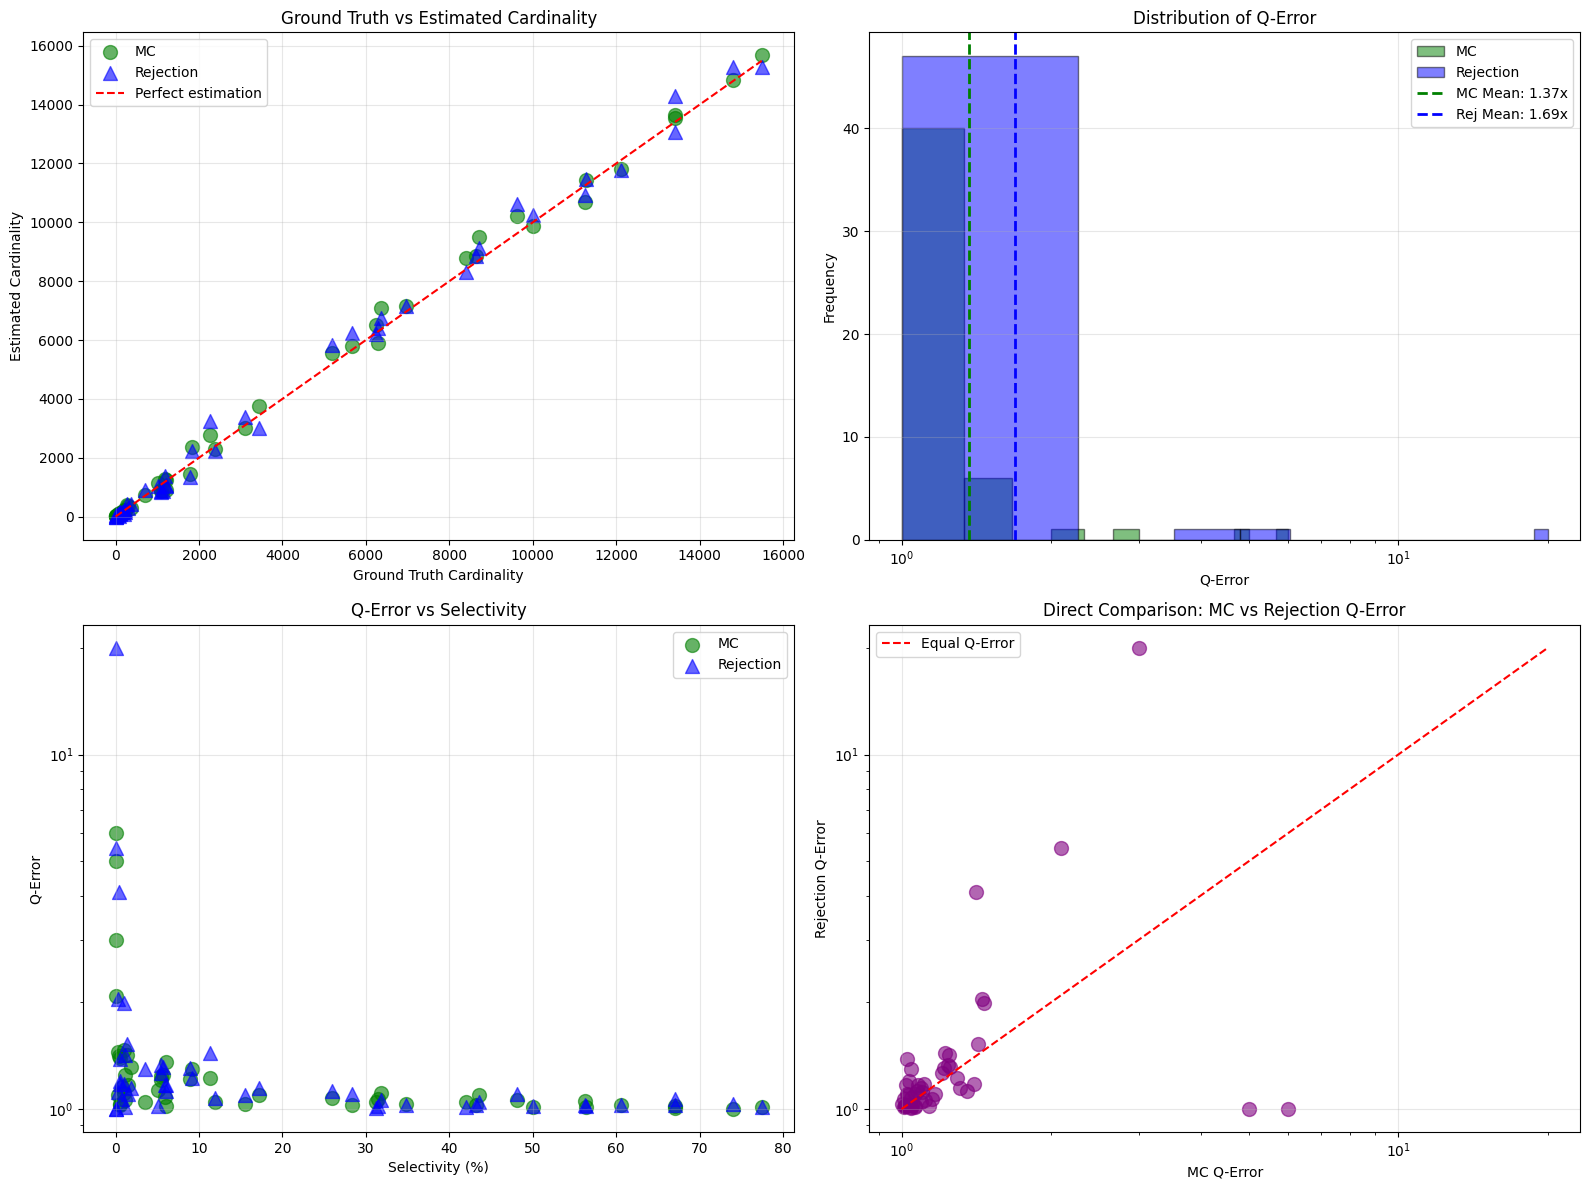


Direct Comparison:
Queries where MC is better:        32/50
Queries where Rejection is better: 18/50
Mean Q-Error difference:           0.325x (Rejection worse)


In [14]:
# Visualize results comparing both methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for both methods
mc_df = results_df[results_df["method"] == "MC"]
rej_df = results_df[results_df["method"] == "Rejection"]

# 1. Ground truth vs Estimated cardinality (both methods)
axes[0, 0].scatter(mc_df["ground_truth_count"], mc_df["estimated_count"], alpha=0.6, s=100, label="MC", color="green")
axes[0, 0].scatter(
    rej_df["ground_truth_count"],
    rej_df["estimated_count"],
    alpha=0.6,
    s=100,
    label="Rejection",
    color="blue",
    marker="^",
)
min_val = min(mc_df["ground_truth_count"].min(), rej_df["ground_truth_count"].min())
max_val = max(mc_df["ground_truth_count"].max(), rej_df["ground_truth_count"].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect estimation")
axes[0, 0].set_xlabel("Ground Truth Cardinality")
axes[0, 0].set_ylabel("Estimated Cardinality")
axes[0, 0].set_title("Ground Truth vs Estimated Cardinality")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Error distribution comparison
axes[0, 1].hist(mc_df["q_error"], bins=15, alpha=0.5, label="MC", color="green", edgecolor="black")
axes[0, 1].hist(rej_df["q_error"], bins=15, alpha=0.5, label="Rejection", color="blue", edgecolor="black")
axes[0, 1].axvline(
    mc_df["q_error"].mean(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"MC Mean: {mc_df['q_error'].mean():.2f}x",
)
axes[0, 1].axvline(
    rej_df["q_error"].mean(),
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Rej Mean: {rej_df['q_error'].mean():.2f}x",
)
axes[0, 1].set_xlabel("Q-Error")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Q-Error")
axes[0, 1].set_xscale("log")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Error vs Selectivity (both methods)
axes[1, 0].scatter(
    mc_df["ground_truth_selectivity"] * 100, mc_df["q_error"], alpha=0.6, s=100, label="MC", color="green"
)
axes[1, 0].scatter(
    rej_df["ground_truth_selectivity"] * 100,
    rej_df["q_error"],
    alpha=0.6,
    s=100,
    label="Rejection",
    color="blue",
    marker="^",
)
axes[1, 0].set_xlabel("Selectivity (%)")
axes[1, 0].set_ylabel("Q-Error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_title("Q-Error vs Selectivity")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Direct comparison: MC Q-Error vs Rejection Q-Error
axes[1, 1].scatter(mc_df["q_error"], rej_df["q_error"], alpha=0.6, s=100, color="purple")
min_qerr = min(mc_df["q_error"].min(), rej_df["q_error"].min())
max_qerr = max(mc_df["q_error"].max(), rej_df["q_error"].max())
axes[1, 1].plot([min_qerr, max_qerr], [min_qerr, max_qerr], "r--", label="Equal Q-Error")
axes[1, 1].set_xlabel("MC Q-Error")
axes[1, 1].set_ylabel("Rejection Q-Error")
axes[1, 1].set_title("Direct Comparison: MC vs Rejection Q-Error")
axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison summary
print("\nDirect Comparison:")
print(f"Queries where MC is better:        {sum(mc_df['q_error'].values < rej_df['q_error'].values)}/{len(mc_df)}")
print(f"Queries where Rejection is better: {sum(rej_df['q_error'].values < mc_df['q_error'].values)}/{len(rej_df)}")
print(
    f"Mean Q-Error difference:           {(rej_df['q_error'].mean() - mc_df['q_error'].mean()):.3f}x "
    + ("(Rejection worse)" if rej_df["q_error"].mean() > mc_df["q_error"].mean() else "(MC worse)")
)

## Using the Cardinality Estimator APIs

Both `MCEstimator` and `RejectionEstimator` provide clean, simple APIs for cardinality estimation:

### Monte Carlo Estimator

```python
from mdbrtools.query import parse_from_mql
from origami.inference import MCEstimator
from origami.utils import compare_estimate_to_ground_truth

# Create estimator
mc_estimator = MCEstimator(model, pipeline, batch_size=1000)

# Define query (MongoDB query language)
query_dict = {"a": {"$gt": 3, "$lt": 5}}
query = parse_from_mql(query_dict)

# Estimate selectivity (returns probability in [0, 1] and generated samples)
p, samples = mc_estimator.estimate(query, n=1000)

# Convert to cardinality
cardinality = p * NUM_DOCS

# Compare to ground truth
result = compare_estimate_to_ground_truth(query, docs, p)
print(f"Estimated: {result['estimated_count']:.1f}, GT: {result['ground_truth_count']}, Q-Error: {result['q_error']:.2f}x")
```

**Key features:**
- Samples uniformly in the query region
- Weights by model probability
- Returns selectivity and generated samples
- Works best for high-selectivity queries (large query regions)

### Rejection Sampling Estimator

```python
from origami.inference import RejectionEstimator, Sampler

# Create estimator
sampler = Sampler(model, encoder, schema)
rejection_estimator = RejectionEstimator(sampler)

# Estimate selectivity (returns probability and accepted samples)
p, accepted_samples = rejection_estimator.estimate(query, n=1000)

# Convert to cardinality
cardinality = p * NUM_DOCS

# Check acceptance rate
print(f"Acceptance rate: {len(accepted_samples)}/1000 = {len(accepted_samples)/10:.1f}%")
```

**Key features:**
- Samples from model distribution
- Counts acceptance rate as selectivity estimate
- Returns selectivity and accepted samples
- Works best for low-selectivity queries (small query regions)
- Unbiased estimator: acceptance_rate = P(query)

### When to Use Each Method

- **MC Estimator**: Best for queries with high selectivity (large query regions). Samples uniformly in the region, so more samples land in the query region.
- **Rejection Estimator**: Best for queries with low selectivity (small query regions). Samples from model where data is dense, so fewer wasted samples.

### Common Features

Both estimators:
- Return unbiased estimates of query selectivity
- Support inspection of generated samples for debugging
- Integrate with ground truth utilities for evaluation
- Handle complete documents with all schema fields
- Support schema-based guardrails via VPDA